<a href="https://colab.research.google.com/github/ChangeEngine/Intro-to-ML--Group-1--Final-Project/blob/main/notebooks/03_mlp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
from pathlib import Path
import sys

REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    # Running in Google Colab
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())


Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [11]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ at ./data or ../data. "
            "Make sure the repo has a data/ folder with the MNIST .gz files."
        )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)


Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - train-labels.idx1-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz
 - t10k-images.idx3-ubyte.gz


In [12]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (4, 4)

train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

(train_images_path, train_labels_path, test_images_path, test_labels_path)


(PosixPath('data/train-images.idx3-ubyte.gz'),
 PosixPath('data/train-labels.idx1-ubyte.gz'),
 PosixPath('data/t10k-images.idx3-ubyte.gz'),
 PosixPath('data/t10k-labels.idx1-ubyte.gz'))

In [13]:
def load_mnist_images(path):
    """Load MNIST images from an idx3-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    """Load MNIST labels from an idx1-ubyte.gz file."""
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, y


In [14]:
# Load full MNIST train/test
X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# Flatten 28x28 -> 784 features
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat :", X_test_flat.shape)

# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_flat: (60000, 784)
X_test_flat : (10000, 784)
Train subset: (48000, 784) (48000,)
Val subset  : (12000, 784) (12000,)


In [15]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),        # standardize features
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(256,),      # one hidden layer with 256 neurons
        activation="relu",
        solver="adam",
        batch_size=128,
        max_iter=20,                    # number of epochs-ish
        early_stopping=True,            # stop when val score stops improving
        n_iter_no_change=3,
        random_state=42,
        verbose=True,
    )),
])

mlp_pipeline


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=128, early_stopping=True,
                               hidden_layer_sizes=(256,), max_iter=20,
                               n_iter_no_change=3, random_state=42,
                               verbose=True))])

In [16]:
print("Training MLP on", X_tr.shape[0], "training samples...")
mlp_pipeline.fit(X_tr, y_tr)
print("Done.")


Training MLP on 48000 training samples...
Iteration 1, loss = 0.28389503
Validation score: 0.954792
Iteration 2, loss = 0.11085645
Validation score: 0.958958
Iteration 3, loss = 0.06809123
Validation score: 0.962708
Iteration 4, loss = 0.04326611
Validation score: 0.968125
Iteration 5, loss = 0.02879521
Validation score: 0.968333
Iteration 6, loss = 0.02000187
Validation score: 0.967292
Iteration 7, loss = 0.01695187
Validation score: 0.970833
Iteration 8, loss = 0.01204731
Validation score: 0.972292
Iteration 9, loss = 0.00888149
Validation score: 0.971042
Iteration 10, loss = 0.01165198
Validation score: 0.972708
Iteration 11, loss = 0.00757657
Validation score: 0.967917
Iteration 12, loss = 0.02306289
Validation score: 0.965000
Iteration 13, loss = 0.02188441
Validation score: 0.968750
Iteration 14, loss = 0.01908489
Validation score: 0.966458
Validation score did not improve more than tol=0.000100 for 3 consecutive epochs. Stopping.
Done.


In [17]:
# Validation
y_val_pred = mlp_pipeline.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average="macro")
val_f1_weighted = f1_score(y_val, y_val_pred, average="weighted")

print("VALIDATION RESULTS (MLP)")
print("Accuracy      :", val_acc)
print("F1 (macro)    :", val_f1_macro)
print("F1 (weighted) :", val_f1_weighted)
print("\nClassification report (validation):\n")
print(classification_report(y_val, y_val_pred))

# Test
y_test_pred = mlp_pipeline.predict(X_test_flat)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

print("\nTEST RESULTS (MLP)")
print("Accuracy      :", test_acc)
print("F1 (macro)    :", test_f1_macro)
print("F1 (weighted) :", test_f1_weighted)


VALIDATION RESULTS (MLP)
Accuracy      : 0.972
F1 (macro)    : 0.9718034444782475
F1 (weighted) : 0.9719849186840026

Classification report (validation):

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1185
           1       0.98      0.99      0.98      1348
           2       0.96      0.97      0.97      1192
           3       0.96      0.96      0.96      1226
           4       0.98      0.98      0.98      1168
           5       0.96      0.98      0.97      1084
           6       0.99      0.98      0.98      1184
           7       0.97      0.97      0.97      1253
           8       0.95      0.95      0.95      1170
           9       0.97      0.96      0.96      1190

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000


TEST RESULTS (MLP)
Accuracy      : 0.9739
F1 (macro)    : 0.9736997732574235
F1 (weig

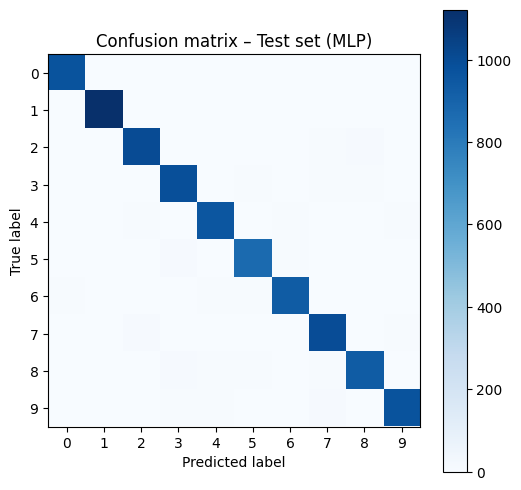

In [18]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion matrix – Test set (MLP)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()
